In [1]:
import sys
sys.path.append("../")

In [59]:
import os

import cv2
import numpy as np

from patchify import patchify, unpatchify

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras import activations

from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    ELU,
    LeakyReLU,
    MaxPool2D,
    PReLU
)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from scripts.prepare_data import convert_images_to_rgb

In [35]:
import tensorflow.keras.backend as K

def modulus_activation(x):
    return K.abs(x)

In [3]:
def make_patches(dir: str, shape: tuple) -> tuple:
    img_patch_shape = (*shape, 3)
    mask_patch_shape = shape

    X = [cv2.imread(f"{dir}/img/{img_name}") for img_name in os.listdir(f'{dir}/img/')]
    X = convert_images_to_rgb(X)

    y = [cv2.imread(f"{dir}/mask/{img_name}", cv2.IMREAD_GRAYSCALE) for img_name in os.listdir(f'{dir}/mask/')]

    X_patchified = [patchify(img, img_patch_shape, step=img_patch_shape[0]) for img in X]
    y_patchified = [patchify(mask, mask_patch_shape, step=mask_patch_shape[0]) for mask in y]

    img_patches, mask_patches = [], []

    for patchified_image in X_patchified:
        for i in range(patchified_image.shape[0]):
            for j in range(patchified_image.shape[1]):
                img_patches.append(patchified_image[i, j, :, :][0])

    for patchified_mask in y_patchified:
        for i in range(patchified_image.shape[0]):
            for j in range(patchified_image.shape[1]):
                mask_patches.append(patchified_mask[i, j, :, :])
    

    return np.array(img_patches), np.array(mask_patches)

In [65]:
train_dir = "../cropped_images/train"
val_dir = "../cropped_images/val"
test_dir = "../cropped_images/test"

patch_shape = (240, 240)

# img_patch_shape = (64, 64, 3)
# mask_patch_shape = (64, 64)
img_patch_shape = (*patch_shape, 3)
mask_patch_shape = patch_shape

# X_train, y_train = make_patches(train_dir, shape=(64, 64))
# X_val, y_val = make_patches(val_dir, shape=(64, 64))
# X_test, y_test = make_patches(test_dir, shape=(64, 64))

X_train, y_train = make_patches(train_dir, shape=patch_shape)
X_val, y_val = make_patches(val_dir, shape=patch_shape)
X_test, y_test = make_patches(test_dir, shape=patch_shape)

train_images_number = X_train.shape[0]
val_images_number = X_val.shape[0]
test_images_number = X_test.shape[0]

batch_size = 4

y_train = y_train.reshape(train_images_number, *mask_patch_shape, 1)
y_val = y_val.reshape(val_images_number, *mask_patch_shape, 1)
y_test = y_test.reshape(test_images_number, *mask_patch_shape, 1)

seed = 42

train_img_datagen_params = dict(rotation_range=90,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            fill_mode='reflect',
                            rescale=1./255
)

train_mask_datagen_params = dict(rotation_range=90,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            fill_mode='reflect',
                            preprocessing_function=lambda x: np.where(x>0, 1, 0).astype(x.dtype)
)

train_datagen_images = ImageDataGenerator(**train_img_datagen_params)
train_datagen_masks = ImageDataGenerator(**train_mask_datagen_params)

train_images = train_datagen_images.flow(X_train, batch_size=batch_size, seed=seed)
train_masks = train_datagen_masks.flow(y_train, batch_size=batch_size, seed=seed)

test_datagen_params = dict(rescale=1./255)

test_datagen_images = ImageDataGenerator(**test_datagen_params)
test_datagen_masks = ImageDataGenerator(**test_datagen_params)

test_images = test_datagen_images.flow(X_test, batch_size=batch_size, seed=seed)
test_masks = test_datagen_masks.flow(y_test, batch_size=batch_size, seed=seed)

val_datagen_images = ImageDataGenerator(**test_datagen_params)
val_datagen_masks = ImageDataGenerator(**test_datagen_params)

val_images = val_datagen_images.flow(X_val, batch_size=batch_size, seed=seed)
val_masks = val_datagen_masks.flow(y_val, batch_size=batch_size, seed=seed)

train_set = zip(train_images, train_masks)
val_set = zip(val_images, val_masks)
test_set = zip(test_images, test_masks)

In [5]:
import tensorflow as tf

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [81]:
kernel_initializer =  'he_uniform'

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization()(x)
    # x = PReLU()(x)
    x = Activation(activations.mish)(x)
    # x = Activation(modulus_activation)(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    # x = PReLU()(x)
    x = Activation(activations.mish)(x)
    
    # x = Activation(modulus_activation)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    # d1 = decoder_block(b1, s4, 512)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [82]:
# model = build_unet((64, 64, 3))
model = build_unet((*patch_shape, 3))
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', dice_coef, Recall(name="recall"), Precision(name="precision")])

In [83]:
callbacks = [
    ModelCheckpoint(filepath="../models/mish_model.hdf5",
                    monitor="val_loss",
                    save_best_only=True),
    EarlyStopping(monitor="val_loss",
                  patience=10,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",
                      factor=0.1,
                      patience=5,
                      verbose=1,
                      min_lr=1e-6)
]

# model.compile(loss=dice_loss, optimizer=Adam(learning_rate=1e-4), metrics=[dice_coef, iou, Recall(), Precision()])

In [84]:
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=300,
                    steps_per_epoch=train_images_number//batch_size,
                    validation_steps=val_images_number//batch_size,
                    callbacks=callbacks)

Epoch 1/300
72/72 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.8108 - dice_coef: 0.4015 - recall: 0.7145 - precision: 0.2925

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 21s 177ms/step - loss: 0.5985 - accuracy: 0.8108 - dice_coef: 0.4015 - recall: 0.7145 - precision: 0.2925 - val_loss: 0.8485 - val_accuracy: 0.3288 - val_dice_coef: 0.1515 - val_recall: 0.7373 - val_precision: 0.0803 - lr: 0.0010
Epoch 2/300
72/72 [==============================] - 11s 151ms/step - loss: 0.4130 - accuracy: 0.9320 - dice_coef: 0.5870 - recall: 0.6731 - precision: 0.5910 - val_loss: 0.8695 - val_accuracy: 0.6268 - val_dice_coef: 0.1305 - val_recall: 0.4277 - val_precision: 0.0747 - lr: 0.0010
Epoch 3/300
72/72 [==============================] - 10s 134ms/step - loss: 0.3315 - accuracy: 0.9428 - dice_coef: 0.6685 - recall: 0.6819 - precision: 0.7002 - val_loss: 0.8670 - val_accuracy: 0.9099 - val_dice_coef: 0.1330 - val_recall: 0.1195 - val_precision: 0.2154 - lr: 0.0010
Epoch 4/300
72/72 [==============================] - 10s 142ms/step - loss: 0.3113 - accuracy: 0.9468 - dice_coef: 0.6887 - recall: 0.6972 - precision: 0.7106 - va

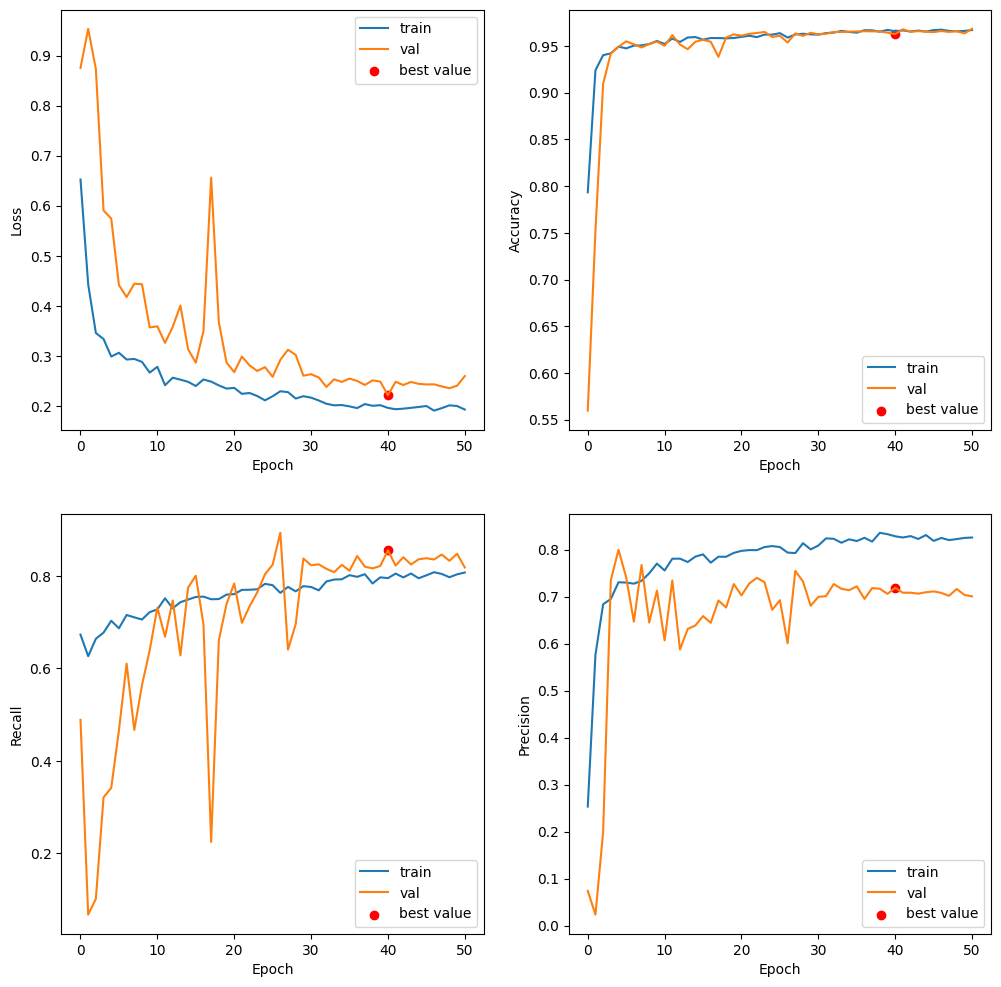

In [77]:
import matplotlib.pyplot as plt

best_epoch = 40

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val', 'best value'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.scatter(best_epoch, history.history['val_accuracy'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.scatter(best_epoch, history.history['val_recall'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.scatter(best_epoch, history.history['val_precision'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.show()

In [55]:
def make_prediction(img: str) -> np.ndarray:
    global patch_shape
    # img_patch_shape = (64, 64, 3)
    # mask_patch_shape = (64, 64)
    img_patch_shape = (*patch_shape, 3)
    mask_patch_shape = patch_shape

    sample_test_img_patchified = patchify(img, patch_size=img_patch_shape, step=img_patch_shape[0])

    number_of_patches = sample_test_img_patchified.shape[0] * sample_test_img_patchified.shape[1]

    sample_test_img_patches = sample_test_img_patchified.reshape(number_of_patches, *img_patch_shape)
    sample_test_img_patches = np.expand_dims(sample_test_img_patches, axis=0)

    y_pred = np.array([model.predict(sample_patch) for sample_patch in sample_test_img_patches]).reshape(sample_test_img_patchified.shape[0], sample_test_img_patchified.shape[0], *mask_patch_shape)

    return unpatchify(y_pred, (960, 960))

1/1 [==============================] - 0s 18ms/step


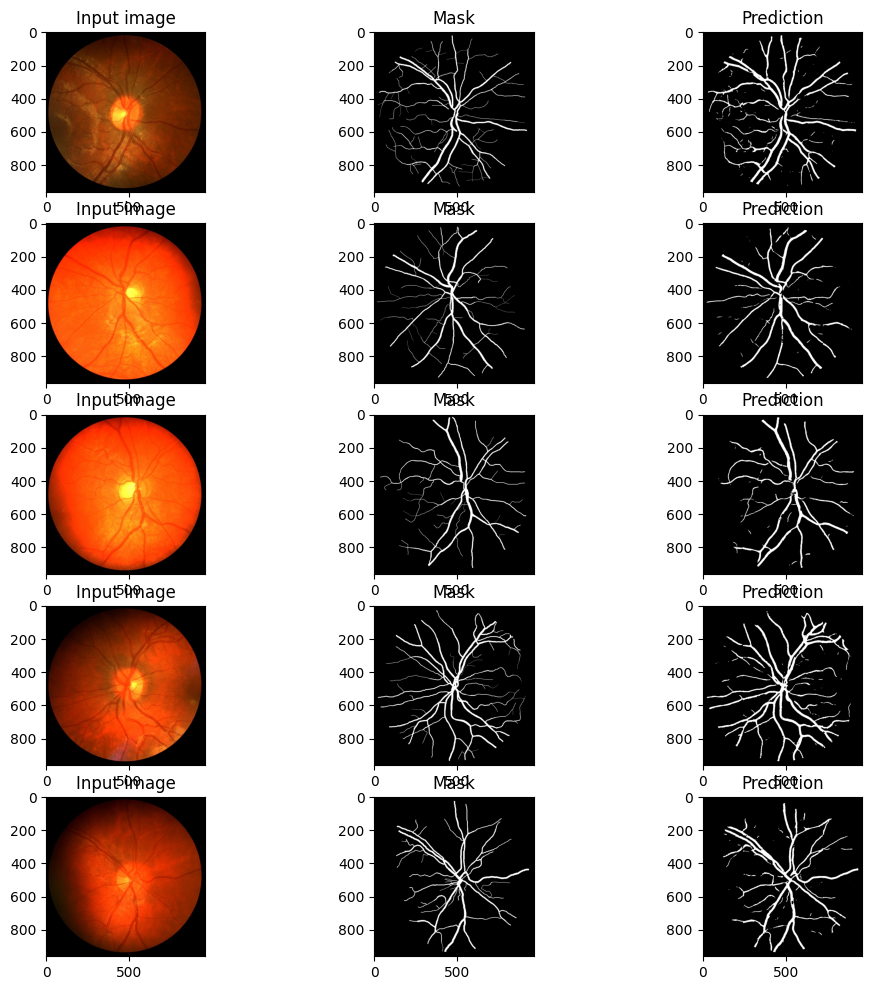

In [78]:
test_images_names = os.listdir(f'{test_dir}/img')
test_masks_names = os.listdir(f'{test_dir}/mask')

test_images = [cv2.imread(f'{test_dir}/img/{img_name}') for img_name in test_images_names]
test_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255 for img in test_images]

test_masks = [cv2.imread(f'{test_dir}/mask/{mask_name}', cv2.IMREAD_GRAYSCALE)/255 for mask_name in test_masks_names]

test_preds = [make_prediction(test_img) for test_img in test_images]

test_preds_binarized = [np.where(pred >= 0.5, 1, 0) for pred in test_preds]

plt.figure(figsize=(12, 12))

for i, (img, pred, mask) in enumerate(zip(test_images, test_preds_binarized, test_masks)):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(img)
    plt.title('Input image')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title('Prediction')

plt.show()

In [79]:
eval_results = model.evaluate(test_set, steps=test_images_number//batch_size, return_dict=True)

20/20 [==============================] - 2s 80ms/step - loss: 0.2572 - accuracy: 0.9648 - dice_coef: 0.7428 - recall: 0.8675 - precision: 0.6705


In [80]:
import json

with open("../results_json/gelu_model_eval.json", "w") as f:
    json.dump(eval_results, f)